In [1]:
from IPython.display import Image

# Policy Based Methods

These notes are from all over the web. Lots of it is from [Udacity Deep Reinforcement Learning](https://classroom.udacity.com/nanodegrees/nd893) course. 

Policy-based methods can learn either stochastic or deterministic policies, and they can be used to solve environments with either finite or continuous action spaces.
There are three reasons why we consider policy-based methods:

- Simplicity: Policy-based methods directly get to the problem at hand (estimating the optimal policy), without having to store a bunch of additional data (i.e., the action values / Q table) that may not be useful.
- Stochastic policies: Unlike value-based methods, policy-based methods can learn true stochastic policies.
- Continuous action spaces: Policy-based methods are well-suited for continuous action spaces.
-------

Below some attempts to solve environments using these methods:

- Black Box Methods
    - [Hill-Climbing](./hill-climbing/Hill_Climbing.ipynb)
    - [Mountain Car Continuous](./cross-entropy/CEM.ipynb) (run this with GPU)

- REINFORCE implementation
    - [Cartpole](./reinforce/REINFORCE.ipynb)
    - [Pong (from pixels)](./pong/pong-REINFORCE.ipynb) (run this with GPU)
    - trained this for a long time with several different network architectures and hyperparameters, still didn't manage to beat the CPU opponent
- Proximal Policy Optimisation implementation (from pixels)
    - [Pong (from pixels)](./pong/pong-PPO.ipynb) (run this with GPU)
    

The above exercises are from [Udacity Deep Reinforcement Learning Git](https://github.com/udacity/deep-reinforcement-learning).

Lessons learntthe hard way - `learning rate` is a very important hyperparameter and can have a huge impact on training process. (spent heaps of time tweaking with)

# 1. Black Box Optimisation Methods

Black box refers to method where we only need a function and change parameters to evaluate the function. Then we check the outcome and reiterate until convergence.


## 1.2. Hill Climbing Algorithm

.. is a relatively simple algorithm to find a (local) minima/maxima of a function.

When training an agent using this algorithm, we can use any function, for example a neural net with for example `tanh` (continuous action spaces) or `softmax` (discrete action spaces) output function to represent the policy function. We want to find a $\theta$ which maximises:
![title](../resources/hill_climbing_formula.JPG)
(formula copied from Udacity Lecture notes)

where *J* is expected return, $\theta$ are weights, $\tau$ trajectory (a state-action sequence ${s_0, a_0, ... s_t, a_t, s_{t+1}}$).

We can use `hill climbing` to find the optimal values for a policy function as follows:

![title](../resources/hill_climbing_pseudocode.JPG)
(pseudocode copied from Udacity Lecture notes)

Replacing expected return *J* with sampled return *G* doesn't yield perfect result, but is often good enough in practice.

## 1.3. Improvements to Hill Climbing Algorithm

We cam add the following improvements to the algorithm to make training process smarter.
- `Steepest ascent hill climbing` is a variation of hill climbing that chooses a small number of neighboring policies at each iteration and chooses the best among them.
- `Simulated annealing` uses a pre-defined schedule to control how the policy space is explored, and gradually reduces the search radius as we get closer to the optimal solution.
- `Adaptive noise scaling` decreases the search radius with each iteration when a new best policy is found, and otherwise increases the search radius.

-----

# 2. Other Black Box Methods
## 2.1. Cross Entropy
The cross-entropy method iteratively suggests a small number of neighboring policies, and uses a small percentage of the best performing policies to calculate a new estimate.

## 2.2. Evolution Strategies
Another interesting improvement to blackbox methods is [Evolution Strategies](https://arxiv.org/abs/1703.03864). The evolution strategies technique considers the return corresponding to each candidate policy. The policy estimate at the next iteration is a weighted sum of all of the candidate policies, where policies that got higher return are given higher weight. 
Look into [this](https://gist.github.com/karpathy/77fbb6a8dac5395f1b73e7a89300318d) piece of code to have a go.

----

# 3 Policy Gradient Methods

At high level, policy gradient method look into all state action pairs in an episode and increases probability of successful actions while it decreases probability of unsuccessful actions.

This is very similar to supervised learning where we put data through the network, get prediction and then adjust weights accordingly. The main difference is that in reinforcement learning setting the dataset changes (state, action) after each episode. 

In reinforcement learning there can be conflicting opinions on which action to take given at a state. This would be equivalent to having a same picture twice with different labels in an image classification exercise. 

Policy gradients learn stochastic policies so we can apply these to learn deterministic policies as well. `Exploration` is also embedded in the learned function and we don't have to force exploration like we have to when using value-based methods.

`
LOOP:
    Collect an episode.
    Change the weights of the policy network
        if WON, increase the probability of each (state, action) combination
        if LOST, decrease the probability of each (state, action) combination
`

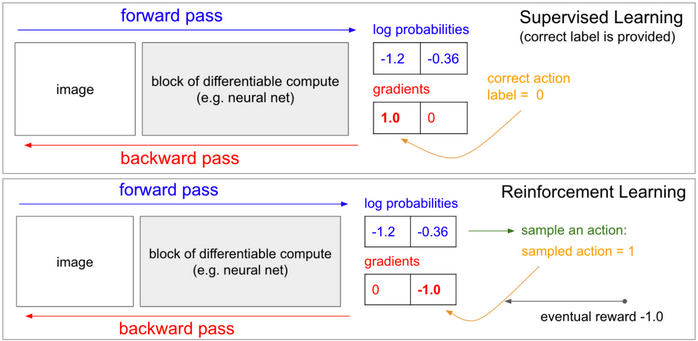



## 3.1. Problem setup

The simplest policy gradient algorithm is called `Reinforce`. When training an agent with policy gradients, our goal is find weights ${\theta}$ in the `neural network` that maximises the `expected return` (on average the agent experiecnes trajectories with high return):
![title](../resources/hill_climbing_formula.JPG)

where ${\tau = s_0, a_0, ... s_H, a_H, s_{H+1}}$ represents `trajectory` and `return` ${R(\tau) = r_1, r_2, ... r_H,r_{H+1}}$ is a function of the `trajectory`. We calculate `weighted average` of the ${R(\tau)}$ where weights are given by ${P(\tau; \theta)}$, which is a probability of all possible values the ${R(\tau)}$ can take. ${H}$ denotes Horizon (often the length of the episode).

We use `trajectories` instead of `episodes`, since there we want to be able to apply this method to `continuous tasks` as well (the length of episode can be infinite).

## 3.2 Finding the ${\theta}$
To optimise this, one way is to use gradient ascent, where we use `estimated gradient` of ${m}$ trajectories, which is then multiplied by reward given the trajectory (calculating the true gradient is not feasible since that would require calculating every possible trajectory).

![reinforce_pseudocode](../resources/reinforce.JPG)

Very detailed way on deriving gradients and implementing reinforce algorithm can be found [here](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd630)

In theory REINFORCE can be used in `continuous` spaces as well, just use an output layer that parametrizes a continuous probability distribution. However "vanilla" REINFORCE doesn't perform well with continuous action spaces.

## 3.3 Noise reduction

There are typically millions of gradients even in simple discrete problem, and infinite for continuous. Most of the time the sampled gradient doesn't contain much information about optimal policy since it's just randomly picked. We can reduce this noise by sampling more trajectories and then estimate the policy gradient by just averaging across all the different trajectories. It's a small tweak to vanilla version but stabilises the training process quite a bit.

![noise_reduction](../resources/noise_reduction.JPG)

When running multiple trajectories like this, we also obtain data to calculate mean and standard deviations, so we can normalise the rewards like so:

![rewards_normalisation](../resources/rewards_normalisation.JPG)

Best practice is to set rewards to 0 in case all rewards are the same and thus ${\sigma = 0}$, to avoid numerical problems.

Intuition behind this is picking half the actions to encourage / discourage while making sure the gradient ascent steps are not too large / small.

## 3.4 Credit Assignment

Since we model these problems as markov decision processes, we don't need to care about the past but only the current moment and the future. So we tweak the gradient calculation like so:

![credit_assignment](../resources/credit_assignment.JPG)

We assume the current reward includes rewards from the past as well so basically we just ignore all rewards which happened in the past. Future rewards:

![credit_assignment2](../resources/credit_assignment2.JPG)

While ignoring past rewards can change gradient for each `trajectory`, it doesn't change average gradient. It also reduces gradient noise and thus should speed up the training process.

# 3.5 Proximal Policy Optimisation

We can also reuse the sampled trajectories. However, we don't want to reuse same samples too many times. 



![surrogate2](./resources/clipped_surrogate2.JPG)

![reward_clip](./resources/policy_reward_cliff.JPG)

![surrogate](./resources/clipped_surrogate.JPG)



PPO algorithm is implemented as follows

1. Collect some trajectories based on some policy ${\pi_\theta}$, and initialize theta prime ${\theta'=\theta}$
2. Next, compute the gradient of the clipped surrogate function using the trajectories
3. Update ${\theta'}$ using gradient ascent ${\theta'\leftarrow\theta+\alpha\nabla_{\theta'}L_{\rm sur}^{\rm clip}(\theta', \theta)}$
4. Then we repeat step 2-3 without generating new trajectories. Typically, step 2-3 are only repeated a few times
5. Set ${\theta=\theta'}$, go back to step 1, repeat.

Source: DRLND notes and [here](https://arxiv.org/pdf/1707.06347.pdf).

-----
# 3. Summary

- In deep reinforcement learning, it is common to represent the policy with a neural network.
    - This network takes the environment state as input.
    - If the environment has discrete actions, the output layer has a node for each possible action and contains the probability that the agent should select each possible action.
- The weights in this neural network are initially set to random values. Then, the agent updates the weights as it interacts with (and learns more about) the environment.
- Policy-based methods can learn either stochastic or deterministic policies, and they can be used to solve environments with either finite or continuous action spaces.

 ${\nabla_\theta log \pi(a_t|s_t) = (1-\theta)' 1/(1-\theta) = -1/(1-\theta) = -1/0.5}$